# Detecting Emotions, Hate Speech & Violence in Text

## Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, GlobalAvgPool1D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

2025-12-09 00:29:41.808320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765232981.937961   50123 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765232981.974742   50123 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765232982.158626   50123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765232982.158769   50123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765232982.158774   50123 computation_placer.cc:177] computation placer alr

---

## Loading Datasets

In [2]:
emotion_df = pd.read_csv("Emotion.csv")
emotion_df

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [3]:
hate_speech_df = pd.read_csv("Hate.csv")
hate_speech_df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
violence_df = pd.read_csv("Violence.csv")
violence_df

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence
...,...,...,...
39645,ID_ZZTLP2L5,"ENTRY 1299: 21F. 23M, BF’s cousin. Got drunk o...",sexual_violence
39646,ID_ZZXB10M6,So you’re telling me Emmanuel Macron was groom...,sexual_violence
39647,ID_ZZY8B7FJ,"My wife regularly beats me, I get dirty slaps ...",Physical_violence
39648,ID_ZZYAFD8L,Me: Hey babe! Police officer boyfriend: is tha...,sexual_violence


---

## Data Preprocessing

### Drop unwanted columns

In [5]:
# emotion
emotion_df.drop(columns=["Unnamed: 0"], inplace=True)
# violence
violence_df.drop(columns=["Tweet_ID"], inplace=True)
# hate speech
hate_speech_df = hate_speech_df[["tweet", "class"]]

### Renaming Columns

In [6]:
print(emotion_df.columns, "\n",hate_speech_df.columns, "\n", violence_df.columns)

Index(['text', 'label'], dtype='object') 
 Index(['tweet', 'class'], dtype='object') 
 Index(['tweet', 'type'], dtype='object')


In [7]:
# emotion
emotion_df.rename(columns={"text": "text", "label": "label"}, inplace=True)
# hate speech
violence_df.rename(columns={"tweet": "text", "type": "label"}, inplace=True)
# violence
hate_speech_df.rename(columns={"tweet": "text", "class": "label"}, inplace=True)

In [8]:
print(emotion_df.columns, "\n",hate_speech_df.columns, "\n", violence_df.columns)

Index(['text', 'label'], dtype='object') 
 Index(['text', 'label'], dtype='object') 
 Index(['text', 'label'], dtype='object')


### Data Shape

In [9]:
emotion_df.shape, hate_speech_df.shape, violence_df.shape

((416809, 2), (24783, 2), (39650, 2))

---

## Label Encoding

In [10]:
le = LabelEncoder()
# emotion ---> Already Encoded
# hate speech ---> Already Encoded
# violence
violence_df.label = le.fit_transform(violence_df.label)

---

### Data Normalization

#### Emotion Dataset

In [11]:
emotion_df.label.value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [12]:
e_df = pd.DataFrame()
for i in range(6):
  subset = emotion_df[emotion_df['label'] == i].sample(n = 2000, random_state = 42)
  e_df = pd.concat([e_df, subset])
emotion_df = e_df.copy()
emotion_df.label.value_counts()

label
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
Name: count, dtype: int64

**Emotions**<br>
`0` : Sadness<br>
`1` : Joy<br>
`2` : Love<br>
`3` : Anger<br>
`4` : Fear<br>
`5` : Surprise

#### Hate Speech Dataset

In [13]:
hate_speech_df.label.value_counts()

label
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [14]:
offensive_speech = hate_speech_df[hate_speech_df['label'] == 1].sample(n = 6407, random_state = 42)
hate_speech_df = hate_speech_df[hate_speech_df['label'] != 1]
hate_speech_df = pd.concat([offensive_speech, hate_speech_df])
hate_speech_df.label.value_counts()

label
1    6407
2    4163
0    1430
Name: count, dtype: int64

**Hate**<br>
`0` : Hate Speech<br>
`1` : Offensive Speech<br>
`2` : Neither

#### Violence Dataset

In [15]:
violence_df.label.value_counts()

label
4    32648
1     5946
3      651
2      217
0      188
Name: count, dtype: int64

In [16]:
sexual_violence = violence_df[violence_df['label'] == 4].sample(n = 4998, random_state = 42)
violence_df = violence_df[violence_df['label'] != 4]
violence_df = pd.concat([sexual_violence, violence_df])
violence_df.label.value_counts()

label
1    5946
4    4998
3     651
2     217
0     188
Name: count, dtype: int64

**Violence**<br>
`0` : Harmful_Traditional_practice<br>
`1` : Physical_violence<br>
`2` : economic_violence<br>
`3` : emotional_violence<br>
`4` : sexual_violence<br>

### Resetting the indexes

In [17]:
emotion_df.reset_index(drop=True, inplace=True)
hate_speech_df.reset_index(drop=True, inplace=True)
violence_df.reset_index(drop=True, inplace=True)

### Data Shape

In [18]:
print(emotion_df.shape, hate_speech_df.shape, violence_df.shape)

(12000, 2) (12000, 2) (12000, 2)


---

## Text Preprocessing

In [19]:
nlp = spacy.load("en_core_web_lg")

In [20]:
# remove stop words and lemmatize the text
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_.lower())

    return " ".join(filtered_tokens)

In [21]:
emotion_df.text = emotion_df.text.apply(preprocess)
hate_speech_df.text = hate_speech_df.text.apply(preprocess)
violence_df.text = violence_df.text.apply(preprocess)

### Text Column after Preprocessing

#### Emotion Dataset

In [22]:
emotion_df.head()

,text,label
0,ve learn surround woman lift leave feeling nur...,0
1,feel crappy upset situation not help,0
2,feel like lose mourn move past tear relationship,0
3,write lot m feel crappy not think feel well,0
4,feel inadequate,0


#### Hate Speech Dataset

In [23]:
hate_speech_df.head()

,text,label
0,everytime cracker barrel girl great tit seat w...,1
1,run nigga want nigga need bad bitch hot,1
2,need girl jamaica fuck basic black bitch,1
3,rt @shadowbeatz_inc know block week bitch @kyr...,1
4,ya hand grade bitch,1


#### Violence Dataset

In [24]:
violence_df.head()

,text,label
0,cousin rap guy matthew restroom matthew go sta...,4
1,hahahahahahahha didn’t time write i’m diab...,4
2,remember get rap like yesterday pull knife nig...,4
3,rap 👈,4
4,woman rap male psychological horror ptsd life ...,4


---

## Tokenization and Padding

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([emotion_df.text, hate_speech_df.text, violence_df.text]))

In [26]:
emotion_sequences = tokenizer.texts_to_sequences(emotion_df.text)
emotion_padded = pad_sequences(emotion_sequences, maxlen=100, padding="post")

hate_speech_sequences = tokenizer.texts_to_sequences(hate_speech_df.text)
hate_speech_padded = pad_sequences(hate_speech_sequences, maxlen=100, padding="post")

violence_sequences = tokenizer.texts_to_sequences(violence_df.text)
violence_padded = pad_sequences(violence_sequences, maxlen=100, padding="post")

---

## Model Building

### Input layer

In [27]:
emotion_input = emotion_padded
hate_speech_input = hate_speech_padded
violence_input = violence_padded

In [28]:
emotion_input_layer = Input(shape=(100,), name='emotion_input')
hate_speech_input_layer = Input(shape=(100,), name='hate_speech_input')
violence_input_layer = Input(shape=(100,), name='violence_input')

### Embedding Layer

In [29]:
embedding_layer = Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim=128)

In [30]:
emotion_embedding = embedding_layer(emotion_input_layer)
hate_speech_embedding = embedding_layer(hate_speech_input_layer)
violence_embedding = embedding_layer(violence_input_layer)

I0000 00:00:1765233854.041892   50123 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Shared LSTM Layer

In [31]:
lstm = LSTM(64, return_sequences=True)

In [32]:
emotion_lstm = lstm(emotion_embedding)
hate_speech_lstm = lstm(hate_speech_embedding)
violence_lstm = lstm(violence_embedding)

### Global Average Pooling Layer

In [33]:
global_avg_pool = GlobalAvgPool1D()

In [34]:
emotion_global_avg = global_avg_pool(emotion_lstm)
hate_speech_global_avg = global_avg_pool(hate_speech_lstm)
violence_global_avg = global_avg_pool(violence_lstm)

### Dropout Layer

In [35]:
dropout = Dropout(0.2)

In [36]:
emotion_dropout = dropout(emotion_global_avg)
hate_speech_dropout = dropout(hate_speech_global_avg)
violence_dropout = dropout(violence_global_avg)

### Output Layer

In [37]:
emotion_output = Dense(6, activation='softmax', name='emotion_output')(emotion_dropout)  # 6 emotion classes
hate_speech_output = Dense(3, activation='softmax', name='hate_speech_output')(hate_speech_dropout)  # 3 hate speech classes
violence_output = Dense(5, activation='softmax', name='violence_output')(violence_dropout)  # 5 violence classes


### Model

In [38]:
model = Model(
    inputs=[
        emotion_input_layer,
        hate_speech_input_layer,
        violence_input_layer
    ],
    outputs=[
        emotion_output,
        hate_speech_output,
        violence_output
    ]
)

### Model Compilation

In [39]:
model.compile(
    optimizer='adam',
    loss={
        'emotion_output': 'sparse_categorical_crossentropy',
        'hate_speech_output': 'sparse_categorical_crossentropy',
        'violence_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'emotion_output': 'accuracy',
        'hate_speech_output': 'accuracy',
        'violence_output': 'accuracy'
    }
)

### Model Summary

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_speech_input   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  4,616,448 │ emotion_input[0]… │
│ (Embedding)         │                   │            │ hate_speech_inpu… │
│                     │                   │            │ violence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 64)   │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ lstm[0][0],       │
│ (GlobalAveragePool… │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        390 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_speech_output  │ (None, 3)         │        195 │ dropout[1][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 5)         │        325 │ dropout[2][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,666,766 (17.80 MB)

 Trainable params: 4,666,766 (17.80 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

#### Labels

In [41]:
emotion_labels = np.array(emotion_df['label'])
violence_labels = np.array(violence_df['label'])
hate_speech_labels = np.array(hate_speech_df['label'])

In [42]:
print("Unique label values:")
print(f"emotion_labels: {np.unique(emotion_labels)}")
print(f"hate_speech_labels: {np.unique(hate_speech_labels)}")
print(f"violence_labels: {np.unique(violence_labels)}")


Unique label values:
emotion_labels: [0 1 2 3 4 5]
hate_speech_labels: [0 1 2]
violence_labels: [0 1 2 3 4]


In [43]:
model.fit(
    x={
        'emotion_input': emotion_input,
        'hate_speech_input': hate_speech_input,
        'violence_input': violence_input
    },
    y={
        'emotion_output': emotion_labels,
        'hate_speech_output': hate_speech_labels,
        'violence_output': violence_labels
    },
    epochs=10,
    batch_size=4
)

Epoch 1/10


I0000 00:00:1765233869.789349   52847 cuda_dnn.cc:529] Loaded cuDNN version 91400


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 354s 113ms/step - emotion_output_accuracy: 0.2734 - emotion_output_loss: 1.6639 - hate_speech_output_accuracy: 0.7502 - hate_speech_output_loss: 0.6914 - loss: 2.6729 - violence_output_accuracy: 0.8961 - violence_output_loss: 0.3175
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 347s 116ms/step - emotion_output_accuracy: 0.4791 - emotion_output_loss: 1.2573 - hate_speech_output_accuracy: 0.8372 - hate_speech_output_loss: 0.4997 - loss: 1.8968 - violence_output_accuracy: 0.9559 - violence_output_loss: 0.1399
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 346s 115ms/step - emotion_output_accuracy: 0.7961 - emotion_output_loss: 0.5716 - hate_speech_output_accuracy: 0.8861 - hate_speech_output_loss: 0.3411 - loss: 0.9704 - violence_output_accuracy: 0.9845 - violence_output_loss: 0.0576
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 332s 111ms/step - emotion_output_accuracy: 0.9304 - emotion_output_loss: 0.2240 - hate_speech_output_accuracy: 0.9360 - hate_speech_output_loss:

---

## Prediction and Evaluation

In [45]:
prediction = model.predict({
    'emotion_input': emotion_input,
    'hate_speech_input': hate_speech_input,  # Changed from 'hate_input'
    'violence_input': violence_input
})

375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step


In [46]:
prediction

[array([[9.9990356e-01, 1.3391707e-05, 6.2088198e-05, 1.9791416e-05,
         8.0906636e-07, 3.8465649e-07],
        [9.9997509e-01, 6.4644964e-06, 7.8704234e-06, 9.7844350e-06,
         7.1571719e-07, 7.1497190e-08],
        [9.9990344e-01, 2.0254434e-05, 4.9529452e-05, 2.3225213e-05,
         3.2095313e-06, 3.1655102e-07],
        ...,
        [9.3029601e-05, 3.7919352e-04, 1.3752469e-05, 3.5807050e-05,
         3.3001125e-02, 9.6647704e-01],
        [2.2050746e-04, 4.2258129e-03, 2.0579288e-04, 1.0065871e-03,
         5.3378236e-03, 9.8900348e-01],
        [1.7745679e-06, 4.2433985e-05, 7.6491788e-06, 1.2428246e-05,
         3.3502979e-04, 9.9960071e-01]], dtype=float32),
 array([[4.1614639e-05, 9.9978882e-01, 1.6961139e-04],
        [9.4907666e-03, 9.9050528e-01, 4.0058571e-06],
        [1.6092967e-05, 9.9995732e-01, 2.6583853e-05],
        ...,
        [9.9996674e-01, 3.2275391e-05, 9.6198039e-07],
        [5.3209815e-06, 6.9875491e-04, 9.9929595e-01],
        [3.3076965e-06, 4.90

In [47]:
emotion_prediction = np.argmax(prediction[0], axis=1)
hate_speech_prediction =np.argmax(prediction[1], axis=1)
violence_prediction = np.argmax(prediction[2], axis=1)

---

## Confusion Matrix

In [48]:
def plot_cm(true, pred, title, labels):
  cf = confusion_matrix(true, pred, normalize = 'true')
  plt.figure(figsize = (7, 6))
  sns.heatmap(cf, annot = True, cmap = 'Blues', xticklabels=labels, yticklabels = labels)
  plt.title(title)
  plt.ylabel('Actual')
  plt.xlabel('Prediction')

#### Labels in Text

In [49]:
emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
hate_speech_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

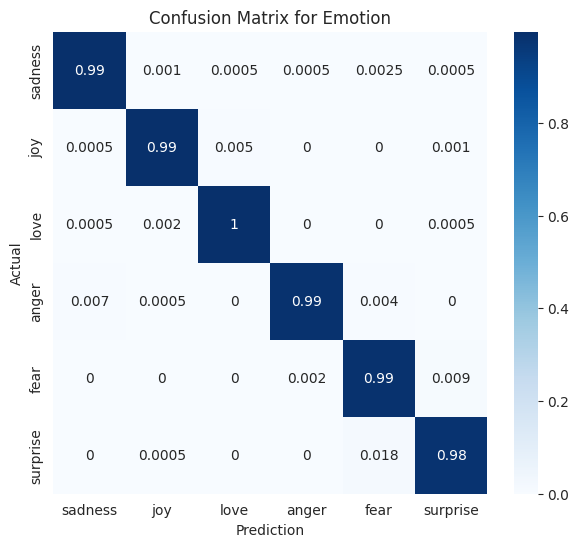

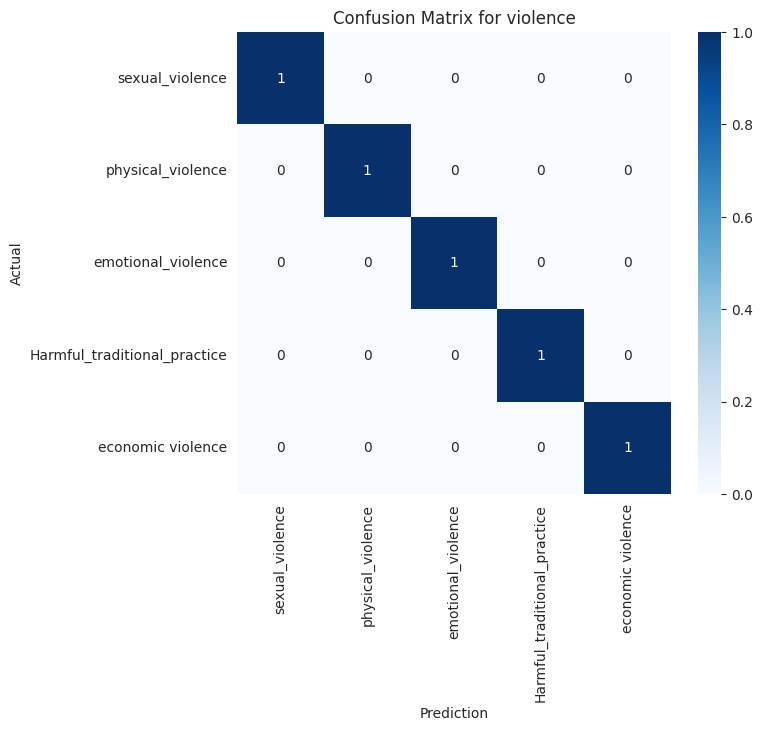

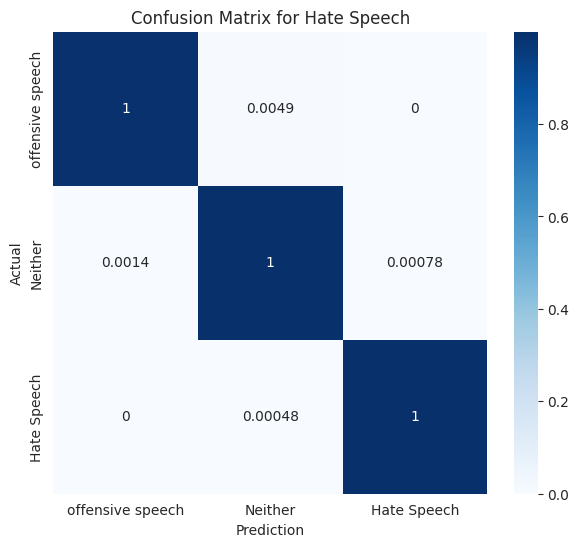

In [50]:
plot_cm(emotion_labels, emotion_prediction, 'Confusion Matrix for Emotion', emotion_labels_text)
plot_cm(violence_labels, violence_prediction, 'Confusion Matrix for violence', violence_labels_text)
plot_cm(hate_speech_labels, hate_speech_prediction, 'Confusion Matrix for Hate Speech', hate_speech_labels_text)

---

## Testing

In [51]:
def classify_text(input_text):
      #preprocess the input text
      input_text_cleaned = preprocess(input_text)
      input_sequence = tokenizer.texts_to_sequences([input_text_cleaned])
      input_padded = pad_sequences(input_sequence, maxlen = 100, padding = 'post')

      #prediction
      predictions = model.predict({
          'emotion_input' : input_padded,
          'violence_input' : input_padded,
          'hate_input' : input_padded
      })

      emotion_pred = np.argmax(predictions[0], axis = 1)[0]
      violence_pred = np.argmax(predictions[1], axis = 1)[0]
      hate_pred = np.argmax(predictions[2], axis = 1)[0]

      #determine major label
      major_labels = ['Emotion', 'Violence', 'Hate Speech']
      major_label_index = np.argmax([np.max(predictions[0]), np.max(predictions[1]), np.max(predictions[2])])
      major_label = major_labels[major_label_index]

      if major_label == 'Emotion':
        sub_label = emotion_labels_text[emotion_pred]
      elif major_label == 'Violence':
        sub_label = violence_labels_text[violence_pred]
      else:
        sub_label = hate_speech_labels_text[hate_pred]

      return major_label, sub_label

### Classification

In [52]:
input_text_widget = widgets.Text(
    description = 'Input text : ',
    placeholder = 'Enter you text'
)
button = widgets.Button(description = 'classify')
output = widgets.Output()

### Function to handle event

In [53]:
def on_button_click(b):
  with output:
    output.clear_output()   #clear the previous output
    input_text = input_text_widget.value
    major_label, sub_label = classify_text(input_text)
    print(f'Major Label : {major_label}')
    print(f'Sub Label : {sub_label}')

#attach the button at bottom
button.on_click(on_button_click)

### Try your own text

In [54]:
display(input_text_widget, button, output)

Text(value='', description='Input text : ', placeholder='Enter you text')

Button(description='classify', style=ButtonStyle())

Output()

---

## Model Saving

In [55]:
model.save('emotion_hate_speech_violence.h5')

---